# Python Tutorium 4: Simulation des Sonnensystem

### Hinweis: Für diese Simulation müssen Sie die folgenden zwei Befehle im aktivierten "exphys1"-Environment ausgeführt haben:

conda install scipy <br>
conda install ipympl <br>

&copy; Physik mit Python, Oliver Natt, Springer, 2022. <br>
TUM-Studierende haben Zugang zu dem Buch über www.ub.tum.de. 

In [ ]:
import numpy as np
import scipy.integrate
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
import mpl_toolkits.mplot3d


# Zeiteinheiten [s] und die Astronomische Einheit [m].
tag = 24 * 60 * 60
jahr = 365.25 * tag
AE = 1.495978707e11

# Simulationszeit und Zeitschrittweite [s]. Je höher du t_max bzw. dt setzt, desto mehr Datenpunkte werden später für die Berechnung der Himmelskörper-Bahnkurven berücksichtigt 
# (d.h. eventuell kann die Berechnung lange dauern und die Animation nachhängen)
t_max = 5 * jahr
dt = 5 * tag

# Namen der simulierten Himmelskörper.
namen = ['Sonne', 'Merkur', 'Venus', 'Erde', 'Mars', 'Jupiter',
         'Saturn', 'Uranus', 'Neptun', 'Tempel 1', '2010TK7']

# Farben für die Darstellung der Himmelskörper.
farben = ['gold', 'darkcyan', 'orange', 'blue', 'red', 'brown',
          'olive', 'green', 'slateblue', 'black', 'gray']

# Newtonsche Gravitationskonstante [m³ / (kg * s²)].
G = 6.6743e-11

# Massen der Himmelskörper [kg].
# Quelle: https://ssd.jpl.nasa.gov/horizons/
# Die Massen von Tempel 1 und 2017TK7 sind geschätzt.
m = np.array([1.3271244004e+20, 2.2031868550e+13, 3.2485859200e+14,
              3.9860043544e+14, 4.2828375214e+13, 1.2668653190e+17,
              3.7931206234e+16, 5.7939512560e+15, 6.8350999700e+15,
              7.2e13 * G, 3e8 * G]) / G

# Lege Datum und Uhrzeit des Simulationsbeginns fest auf
# den 01.01.2022 um 00:00 Uhr UTC.
datum_t0 = datetime.datetime(year=2022, month=1, day=1)

# Positionen [m] und Geschwindigkeiten [m/s] der Himmelskörper zum
# Startzeitpunkt. Quelle: https://ssd.jpl.nasa.gov/horizons/
r0 = AE * np.array([
    [-8.5808349915e-03, +3.3470429582e-03, +1.7309053212e-04],
    [+3.5044731459e-01, -3.7407373056e-02, -3.6089929256e-02],
    [-7.6445799950e-02, +7.1938215866e-01, +1.3916787662e-02],
    [-1.8324185857e-01, +9.7104012872e-01, +1.2685882047e-04],
    [-8.7535457155e-01, -1.2654778061e+00, -5.1567061263e-03],
    [+4.6495009432e+00, -1.7912164410e+00, -9.6589634761e-02],
    [+6.9514956851e+00, -7.0632684291e+00, -1.5395337276e-01],
    [+1.4389044567e+01, +1.3482065167e+01, -1.3633986727e-01],
    [+2.9624686966e+01, -4.0872817514e+00, -5.9856130334e-01],
    [-1.4276620837e+00, -8.4076159551e-01, +1.8789874266e-01],
    [-3.9399052555e-01, +7.1652579640e-01, +1.1583105373e-01]])
v0 = AE / tag * np.array([
    [-3.3551917266e-06, -8.4435230812e-06, +1.4516419864e-07],
    [-2.2707582290e-03, +2.9204389319e-02, +2.5953443972e-03],
    [-2.0208176480e-02, -2.0266237759e-03, +1.1383547310e-03],
    [-1.7213898896e-02, -3.1295322660e-03, +3.5869599301e-07],
    [+1.2076503589e-02, -6.7024690766e-03, -4.3646377051e-04],
    [+2.6221777732e-03, +7.3957409953e-03, -8.9347514907e-05],
    [+3.6639554949e-03, +3.9017145704e-03, -2.1374264507e-04],
    [-2.7180766241e-03, +2.6868888270e-03, +4.5192378845e-05],
    [+4.0824560317e-04, +3.1283037388e-03, -7.3829594992e-05],
    [+1.0774018377e-02, -1.1795045602e-02, -2.6462859590e-03],
    [-1.6051208207e-02, -1.1225888345e-02, +6.5703843151e-03]])

### Funktion zur Berechung der DGL

In [ ]:
def dgl(t, u):
    """Berechne die rechte Seite der Differentialgleichung."""
    r, v = np.split(u, 2)
    r = r.reshape(n_koerper, n_dim)
    a = np.zeros((n_koerper, n_dim))
    for i in range(n_koerper):
        for j in range(i):
            dr = r[j] - r[i]
            gr = G / np.linalg.norm(dr) ** 3 * dr
            a[i] += gr * m[j]
            a[j] -= gr * m[i]
    return np.concatenate([v, a.reshape(-1)])

### Berechnung des Orts und der Geschwindigkeit der Himmelskörper

In [ ]:
# Anzahl der Himmelskörper und Dimension des Raumes.
n_koerper, n_dim = r0.shape

# Ziehe die Schwerpunktsposition und -geschwindigkeit von den
# Anfangsbedingungen ab.
r0 -= m @ r0 / np.sum(m)
v0 -= m @ v0 / np.sum(m)

# Lege den Zustandsvektor zum Zeitpunkt t=0 fest.
u0 = np.concatenate((r0.reshape(-1), v0.reshape(-1)))

# Löse die Bewegungsgleichung bis zum Zeitpunkt t_max.
result = scipy.integrate.solve_ivp(dgl, [0, t_max], u0, rtol=1e-9,
                                   t_eval=np.arange(0, t_max, dt))
t = result.t
r, v = np.split(result.y, 2)

# Wandle r und v in ein 3-dimensionales Array um:
#    1. Index - Himmelskörper
#    2. Index - Koordinatenrichtung
#    3. Index - Zeitpunkt
r = r.reshape(n_koerper, n_dim, -1)
v = v.reshape(n_koerper, n_dim, -1)

### ... oder importiere die bereits berechneten Daten ('ephemeriden.npz')

In [ ]:
# import numpy as np
# import datetime
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.animation
# import mpl_toolkits.mplot3d

# # Lies die Simulationsdaten ein.
# dat = np.load('ephemeriden.npz')
# tag, jahr, AE, G = dat['tag'], dat['jahr'], dat['AE'], dat['G']
# dt, namen = dat['dt'], dat['namen']
# m, t, r, v = dat['m'], dat['t'], dat['r'],  dat['v']
# datum_t0 = datetime.datetime.fromtimestamp(float(dat['datum_t0']))

# # Stelle nur jeden n-ten simulierten Zeitschritt dar, damit die
# # Animation nicht zu langsam wird.
# schritt = int(300 * tag / dt)

# # Farben für die Darstellung der Himmelskörper.
# farben = ['gold', 'darkcyan', 'orange', 'blue', 'red', 'brown',
#           'olive', 'green', 'slateblue', 'black', 'gray']

# # Anzahl der Himmelskörper und Dimension des Raumes.
# n_koerper, n_dim = r.shape[:2]

### Darstellung der Bahnkurven der Himmelskörper

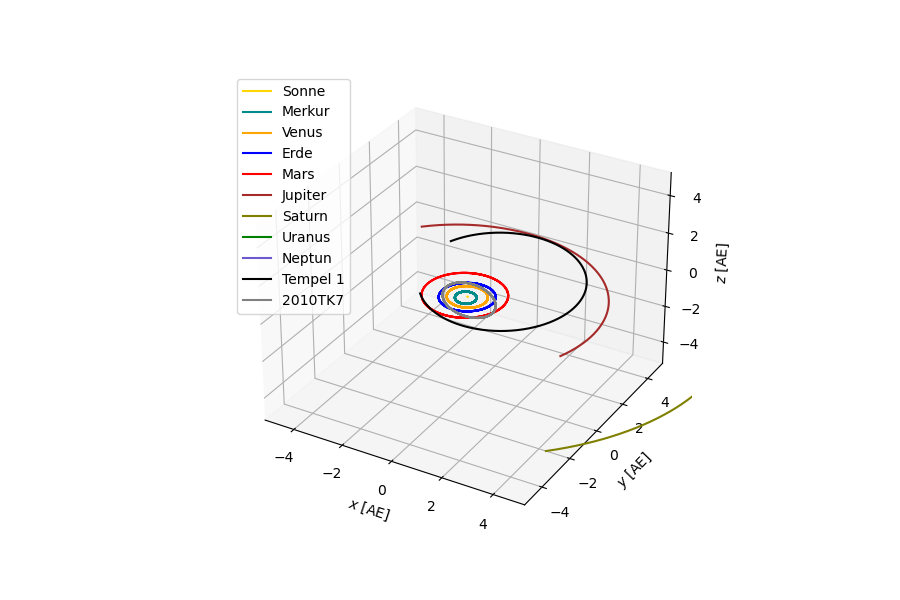

In [ ]:
%matplotlib widget

# Erzeuge eine Figure und eine 3D-Axes für die Bahnkurven.
fig_bahn = plt.figure(figsize=(9, 6))
ax_bahn = fig_bahn.add_subplot(1, 1, 1, projection='3d')
ax_bahn.set_xlabel('$x$ [AE]')
ax_bahn.set_ylabel('$y$ [AE]')
ax_bahn.set_zlabel('$z$ [AE]')
ax_bahn.set_xlim(-5, 5)
ax_bahn.set_ylim(-5, 5)
ax_bahn.set_zlim(-5, 5)
ax_bahn.grid()

# Plotte für jeden Himmelskörper die Bahnkurve und füge die
# Legende hinzu.
for ort, name, farbe in zip(r, namen, farben):
    ax_bahn.plot(ort[0] / AE, ort[1] / AE, ort[2] / AE,
                 '-', color=farbe, label=name)
ax_bahn.legend()

# Erzeuge für jeden Himmelskörper einen Punktplot in der
# entsprechenden Farbe und speichere diesen in der Liste.
plots_himmelskoerper = []
for farbe in farben:
    plot, = ax_bahn.plot([], [], [], 'o', color=farbe)
    plots_himmelskoerper.append(plot)

# Füge ein Textfeld für die Anzeige der verstrichenen Zeit hinzu.
text_zeit = fig_bahn.text(0.5, 0.95, '')


def update(n):
    """Aktualisiere die Grafik zum n-ten Zeitschritt."""
    for plot, ort in zip(plots_himmelskoerper, r):
        plot.set_data_3d(ort[:, n].reshape(-1, 1) / AE)

    # Berechne das aktuelle Datum und stelle den Zeitpunkt dar.
    datum = datum_t0 + datetime.timedelta(seconds=t[n])
    text_zeit.set_text(f'{t[n] / jahr:.2f} Jahre: {datum:%d.%m.%Y}')
    return plots_himmelskoerper + [text_zeit]


# Erzeuge das Animationsobjekt und starte die Animation.
ani = mpl.animation.FuncAnimation(fig_bahn, update, frames=t.size,
                                  interval=30)
plt.show()

### Bonus: Berechnung der Energien, Impulse und Schwerpunkt-Positionen 

In [ ]:
# Berechne die verschiedenen Energiebeiträge.
E_kin = 1/2 * m @ np.sum(v * v, axis=1)
E_pot = np.zeros(t.size)
for i in range(n_koerper):
    for j in range(i):
        dr = np.linalg.norm(r[i] - r[j], axis=0)
        E_pot -= G * m[i] * m[j] / dr
E = E_pot + E_kin

# Berechne den Gesamtimpuls.
impuls = m @ v.swapaxes(0, 1)

# Berechne die Position des Schwerpunktes.
schwerpunkt = m @ r.swapaxes(0, 1) / np.sum(m)

# Berechne den Drehimpuls.
drehimpuls = m @ np.cross(r, v, axis=1).swapaxes(0, 1)

### Darstellung der Energien, Impulse und Schwerpunkt-Positionen 

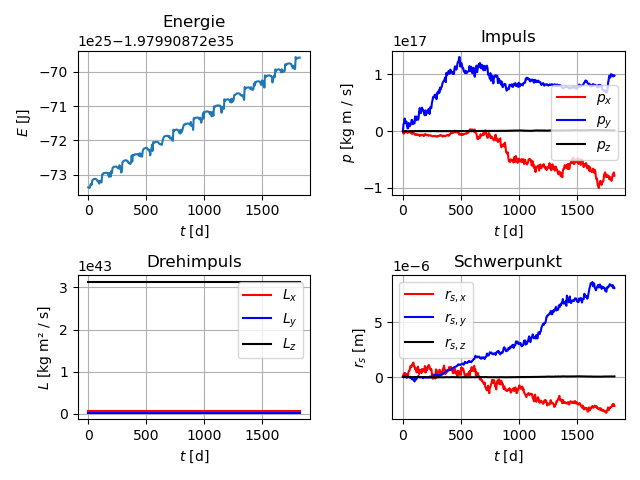

In [ ]:
%matplotlib widget

# Erzeuge eine Figure für die Plots der Erhaltungsgrößen.
fig_plots = plt.figure()
fig_plots.set_tight_layout(True)

# Erzeuge eine Axes und plotte die Energie.
ax_energ = fig_plots.add_subplot(2, 2, 1)
ax_energ.set_title('Energie')
ax_energ.set_xlabel('$t$ [d]')
ax_energ.set_ylabel('$E$ [J]')
ax_energ.grid()
ax_energ.plot(t / tag, E, label='$E$')

# Erzeuge eine Axes und plotte den Impuls.
ax_impuls = fig_plots.add_subplot(2, 2, 2)
ax_impuls.set_title('Impuls')
ax_impuls.set_xlabel('$t$ [d]')
ax_impuls.set_ylabel('$p$ [kg m / s]')
ax_impuls.grid()
ax_impuls.plot(t / tag, impuls[0, :], '-r', label='$p_x$')
ax_impuls.plot(t / tag, impuls[1, :], '-b', label='$p_y$')
ax_impuls.plot(t / tag, impuls[2, :], '-k', label='$p_z$')
ax_impuls.legend()

# Erzeuge eine Axes und plotte den Drehimpuls.
ax_drehimpuls = fig_plots.add_subplot(2, 2, 3)
ax_drehimpuls.set_title('Drehimpuls')
ax_drehimpuls.set_xlabel('$t$ [d]')
ax_drehimpuls.set_ylabel('$L$ [kg m² / s]')
ax_drehimpuls.grid()
ax_drehimpuls.plot(t / tag, drehimpuls[0, :], '-r', label='$L_x$')
ax_drehimpuls.plot(t / tag, drehimpuls[1, :], '-b', label='$L_y$')
ax_drehimpuls.plot(t / tag, drehimpuls[2, :], '-k', label='$L_z$')
ax_drehimpuls.legend()

# Erzeuge eine Axes und plotte die Schwerpunktskoordinaten.
ax_schwerpunkt = fig_plots.add_subplot(2, 2, 4)
ax_schwerpunkt.set_title('Schwerpunkt')
ax_schwerpunkt.set_xlabel('$t$ [d]')
ax_schwerpunkt.set_ylabel('$r_s$ [m]')
ax_schwerpunkt.grid()
ax_schwerpunkt.plot(t / tag, schwerpunkt[0, :], '-r',
                    label='$r_{s,x}$')
ax_schwerpunkt.plot(t / tag, schwerpunkt[1, :], '-b',
                    label='$r_{s,y}$')
ax_schwerpunkt.plot(t / tag, schwerpunkt[2, :], '-k',
                    label='$r_{s,z}$')
ax_schwerpunkt.legend()

# Copyright

&copy; Physik mit Python, Oliver Natt, Springer, 2022. <br>
TUM-Studierende haben Zugang zu dem Buch über www.ub.tum.de. 

Copyright (c) 2023 Springer Nature Code Inside

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
